# **Explicación del dataset**

1.   TRANSACTION_ID: Identificador único para cada transacción.
2. FECHA: Fecha y hora de la transacción.
3. HORA: Identificador único para cada cliente.
4. TERMINAL_ID: Identificador único para cada terminal.
5. IMPORTE_TRANSACCION: Monto de la transacción.
6. TIEMPO_SEG_TRANSACCION: Tiempo en segundos desde el inicio del conjunto de datos.
7. TIEMPO_DIAS_TRANSACCION: Tiempo en días desde el inicio del conjunto de datos.
8. FRAUDE: Indicador binario (0 o 1) que denota si la transacción es fraudulenta (1) o no (0).
9. ESCNERARIO_FRAUDE: Código numérico que representa el escenario de fraude asociado con la transacción. Hay 4 casos (0,1,2,3).

El conjunto de datos permite analizar los patrones de transacción, detectar fraudes y comprender la relación entre diferentes atributos de transacción y el fraude.

# **`MODELO DE CLASIFICACIÓN DE TRANSFERENCIAS`**




In [2]:
#Importamos librerias que se vayan a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("Final Transactions.csv", delimiter=";", header=None)
# Elimina la primera línea de la tabla
data = data.iloc[1:]
# Restablece los índices de las filas
data = data.reset_index(drop=True)
# Restablece los encabezados de las columnas
data.columns = ['ID_TRANSACCION', 'DIA', 'HORA', 'ID_CLIENTE', 
                'TERMINAL_ID', 'IMPORTE_TRANSACCION', 'TIEMPO_SEG_TRANSACCION', 
                'TIEMPO_DIAS_TRANSACCION', 'FRAUDE', 'ESCENARIO_FRAUDE']

<ipython-input-3-6a8bc96c6bbd>:1: DtypeWarning: Columns (0,3,4,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Final Transactions.csv", delimiter=";", header=None)


In [4]:
data.head()  # Muestra las primeras filas del conjunto de datos

,ID_TRANSACCION,DIA,HORA,ID_CLIENTE,TERMINAL_ID,IMPORTE_TRANSACCION,TIEMPO_SEG_TRANSACCION,TIEMPO_DIAS_TRANSACCION,FRAUDE,ESCENARIO_FRAUDE
0,0,1/1/23,0:00:31,596,3156,533.07,31,0,0,0
1,1,1/1/23,0:02:10,4961,3412,808.56,130,0,0,0
2,2,1/1/23,0:07:56,2,1365,1442.94,476,0,1,1
3,3,1/1/23,0:09:29,4128,8737,620.65,569,0,0,0
4,4,1/1/23,0:10:34,927,9906,490.66,634,0,0,0


# **EDA**

Antes de entrenar un modelo predictivo o de realizar cualquier cálculo con un nuevo
conjunto de datos, es muy importante realizar una exploraciín descriptiva de los mismos.
Tiene como objetivo comprender los datos y extraer información relevante a través de
diversas técnicas.

**Tipo de datos**

Una de las primeras cosas que hay que hacer tras cargar los datos es visualizar su
estructura. 

In [5]:
data.shape

(1048575, 10)

La dimensión del conjunto de datos es bastante grande, pues tiene más de un millón de datos repartidos en 10 variables.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   ID_TRANSACCION           1048575 non-null  object
 1   DIA                      1048575 non-null  object
 2   HORA                     1048575 non-null  object
 3   ID_CLIENTE               1048575 non-null  object
 4   TERMINAL_ID              1048575 non-null  object
 5   IMPORTE_TRANSACCION      1048575 non-null  object
 6   TIEMPO_SEG_TRANSACCION   1048575 non-null  object
 7   TIEMPO_DIAS_TRANSACCION  1048575 non-null  object
 8   FRAUDE                   1048575 non-null  object
 9   ESCENARIO_FRAUDE         1048575 non-null  object
dtypes: object(10)
memory usage: 80.0+ MB


En esta primera vista se observa que los datos están clasificados de tipo objeto. Tampoco se ven datos nulos.

Con el siguiente código se cambian a sus tipos correspondientes:

In [7]:
import datetime
from dateutil import parser
from datetime import datetime
data['ID_TRANSACCION'] = pd.to_numeric(data['ID_TRANSACCION'], errors='coerce')
data['DIA'] = pd.to_datetime(data['DIA'], errors='coerce')
data['ID_CLIENTE'] = pd.to_numeric(data['ID_CLIENTE'], errors='coerce')
data['TERMINAL_ID'] = pd.to_numeric(data['TERMINAL_ID'], errors='coerce')
data['IMPORTE_TRANSACCION'] = pd.to_numeric(data['IMPORTE_TRANSACCION'], errors='coerce')
data['TIEMPO_SEG_TRANSACCION'] = pd.to_numeric(data['TIEMPO_SEG_TRANSACCION'], errors='coerce')
data['TIEMPO_DIAS_TRANSACCION'] = pd.to_numeric(data['TIEMPO_DIAS_TRANSACCION'], errors='coerce')
data['FRAUDE'] = pd.to_numeric(data['FRAUDE'], errors='coerce')
data['ESCENARIO_FRAUDE'] = pd.to_numeric(data['ESCENARIO_FRAUDE'], errors='coerce')

Todos los datos son de tipo númerico, execpto fecha y hora que pasan a ser tipo datatime.


 Aunque en la descripción de los datos no parecía haber ningún dato faltante, se puede confirmar con el siguiente código:

In [8]:
null_values = data.isnull().sum()
print(null_values)
#al convern¡tir los valores a nulos se pierden 470 datos de importe

ID_TRANSACCION               0
DIA                          0
HORA                         0
ID_CLIENTE                   0
TERMINAL_ID                  0
IMPORTE_TRANSACCION        470
TIEMPO_SEG_TRANSACCION       0
TIEMPO_DIAS_TRANSACCION      0
FRAUDE                       0
ESCENARIO_FRAUDE             0
dtype: int64


Al parecer hay 470 datos perdidos en la variable Importe_transaccion. Estos datos se han perdido al cambiar la variable de tipo.

El siguiente paso es analizar mediante funciones y gráficos cada variable del data set para profundizar en su compresión.

**VARIABLE RESPUESTA**

El objetivo de este problema es clasfificar las trnasferencias según sean fraudulentas o no. Por eso es imprescindible analizar la variable respuesta que representa a este objetivo, que es la variable '**Fraude**'

In [9]:
# Calcular el recuento de transferencias fraudulentas y no fraudulentas
count_fraudes = data['FRAUDE'].value_counts()

# Obtener el recuento de transferencias fraudulentas
total_fraudes = count_fraudes.get(1, 0)

# Obtener el recuento de transferencias no fraudulentas
total_no_fraudes = count_fraudes.get(0, 0)

print("Total de transferencias fraudulentas: ", total_fraudes)
print("Total de transferencias no fraudulentas: ", total_no_fraudes)

Total de transferencias fraudulentas:  140473
Total de transferencias no fraudulentas:  908102


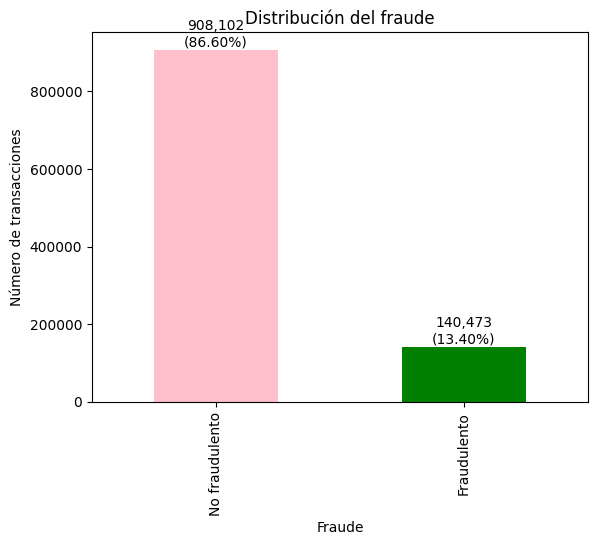

In [10]:

# Calcular la frecuencia de transacciones fraudulentas y no fraudulentas
fraude_counts = data['FRAUDE'].value_counts()

# Calcular los porcentajes de transacciones fraudulentas y no fraudulentas
fraude_perc = fraude_counts / len(data) * 100

# Crear un gráfico de barras para representar la distribución del fraude con porcentajes
fraude_counts.plot(kind='bar', color=['pink', 'green'])

plt.xlabel('Fraude')
plt.ylabel('Número de transacciones')
plt.title('Distribución del fraude')
plt.xticks([0, 1], ['No fraudulento', 'Fraudulento'])

# Mostrar los porcentajes en las barras
for i, v in enumerate(fraude_counts):
    plt.text(i, v + 10000, f'{v:,}\n({fraude_perc[i]:.2f}%)', ha='center')

plt.show()


El total de transferencias fraudulentas en todo el data set. Mayoritariamente las transferencias que se realizan no son fraudulentas, como era de esperar. 

El total de transferencias fraudulentas representan un 13.40% en los últimos meses. 

<ipython-input-11-8f0fc78b97d1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transferencias_fraudulentas['MES'] = transferencias_fraudulentas['DIA'].dt.month
<ipython-input-11-8f0fc78b97d1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transferencias_no_fraudulentas['MES'] = transferencias_no_fraudulentas['DIA'].dt.month


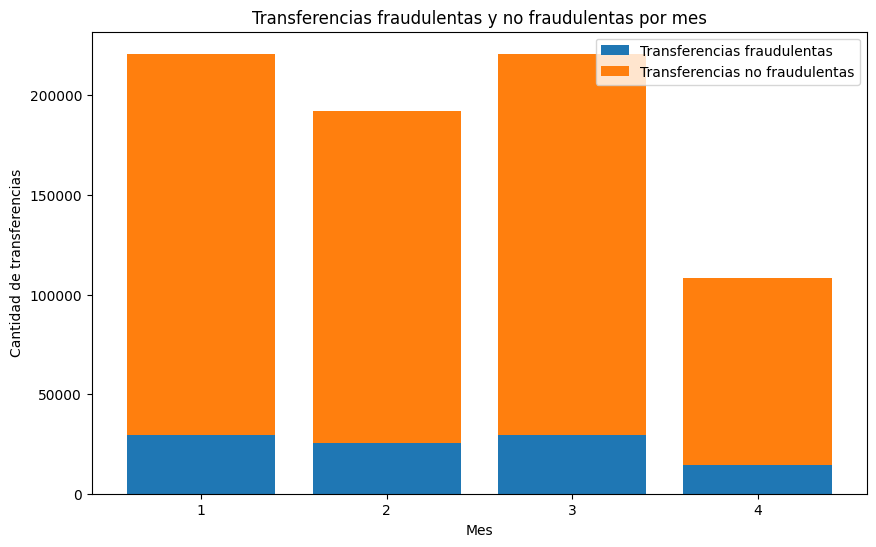

In [11]:
##Gráfico por meses##

# Filtrar las transferencias fraudulentas y no fraudulentas
transferencias_fraudulentas = data[data['FRAUDE'] == 1]
transferencias_no_fraudulentas = data[data['FRAUDE'] == 0]

# Obtener el total de transferencias fraudulentas y no fraudulentas por mes
transferencias_fraudulentas['MES'] = transferencias_fraudulentas['DIA'].dt.month
transferencias_no_fraudulentas['MES'] = transferencias_no_fraudulentas['DIA'].dt.month

total_fraudulentas_por_mes = transferencias_fraudulentas['MES'].value_counts().sort_index()
total_no_fraudulentas_por_mes = transferencias_no_fraudulentas['MES'].value_counts().sort_index()

# Combinar los datos y rellenar meses faltantes con ceros
meses = range(1, 5)  # Considerando los meses de enero a abril
total_fraudulentas_por_mes = total_fraudulentas_por_mes.reindex(meses, fill_value=0)
total_no_fraudulentas_por_mes = total_no_fraudulentas_por_mes.reindex(meses, fill_value=0)

# Graficar
plt.figure(figsize=(10, 6))
plt.bar(meses, total_fraudulentas_por_mes, label='Transferencias fraudulentas')
plt.bar(meses, total_no_fraudulentas_por_mes, bottom=total_fraudulentas_por_mes, label='Transferencias no fraudulentas')
plt.xlabel('Mes')
plt.ylabel('Cantidad de transferencias')
plt.title('Transferencias fraudulentas y no fraudulentas por mes')
plt.xticks(meses)
plt.legend()
plt.show()


Con este gráfico, se puede apreciar que el mes con menos transferencias fraudulentas ha sido Abril, mientras que en enero y marzo parece haber una similitud en cuento al número de transferencias enviadas.

**Variable ID_CLIENTE**

In [12]:

# Calcular la frecuencia de transacciones por cliente
frecuencia_transacciones = data['ID_CLIENTE'].value_counts().reset_index()

# Renombrar las columnas
frecuencia_transacciones.columns = ['Cliente', 'Frecuencia']

# Imprimir la tabla de frecuencia
print(frecuencia_transacciones)



      Cliente  Frecuencia
0        2891         477
1        2580         464
2        1953         455
3        2932         454
4        3864         453
...       ...         ...
4981     1880           1
4982     1942           1
4983     4866           1
4984     3801           1
4985     1095           1

[4986 rows x 2 columns]


Se analiza la frecuencia en que los clientes han realizado una transferencia en los últimos 4 meses, siendo la cantidad de transferencias enviadas por un cliente más alta 477.

In [13]:
cliente_especifico = 2 # Reemplaza 'ID_DEL_CLIENTE' con el ID del cliente específico que deseas buscar

# Filtrar las transferencias fraudulentas
transferencias_fraudulentas = data[data['FRAUDE'] == 1]

# Contar el número de transferencias fraudulentas por cliente
conteo_por_cliente = transferencias_fraudulentas.groupby('ID_CLIENTE').size()

# Verificar si el cliente específico ha realizado más de una transferencia fraudulenta
if cliente_especifico in conteo_por_cliente.index:
    num_transferencias_fraudulentas = conteo_por_cliente.loc[cliente_especifico]
    if num_transferencias_fraudulentas > 1:
        print(f"El cliente {cliente_especifico} ha realizado más de una transferencia fraudulenta.")
    else:
        print(f"El cliente {cliente_especifico} ha realizado una transferencia fraudulenta.")
else:
    print(f"No se encontraron transferencias fraudulentas para el cliente {cliente_especifico}.")



El cliente 2 ha realizado más de una transferencia fraudulenta.


El código anterior facilita la búsqueda por cliente de si ha realizado 1 o más transferencias fraudulentas. 

**Variable Fecha**

In [14]:
# Agrupar por día y calcular el número total de transferencias
total_dia = data.groupby('DIA').size().sort_values(ascending=False)
media_dia = data.groupby('DIA').size().mean()

print("Total de transferencias  por día:")
print(total_dia)
print("\nMedia de transferencias  por día:")
print(media_dia)


Total de transferencias  por día:
DIA
2023-01-04    9789
2023-06-04    9784
2023-02-02    9771
2023-02-15    9767
2023-01-30    9760
              ... 
2023-07-02    9432
2023-02-03    9422
2023-02-22    9399
2023-02-23    9376
2023-04-20    3386
Length: 110, dtype: int64

Media de transferencias  por día:
9532.5


Con estos datos, se observa que el día que más transferencias fraudulentas se han realizado ha sido el 1 de abril de 2023, siendo la media de transferencias realizadas por día de 9532 aprox.

In [15]:
# Filtrar las transferencias fraudulentas
transferencias_fraudulentas = data[data['FRAUDE'] == 1]

# Agrupar por día y calcular el total y la media de transferencias fraudulentas
total_por_dia = transferencias_fraudulentas.groupby('DIA').size().sort_values(ascending=False)
media_por_dia = transferencias_fraudulentas.groupby('DIA').size().mean()

# Mostrar los resultados
print("Total de transferencias fraudulentas por día:")
print(total_por_dia)
print("\nMedia de transferencias fraudulentas por día:")
print(media_por_dia)


Total de transferencias fraudulentas por día:
DIA
2023-02-02    1414
2023-10-03    1365
2023-01-23    1356
2023-01-31    1350
2023-01-13    1349
              ... 
2023-01-01    1208
2023-03-26    1205
2023-09-01    1186
2023-02-01    1182
2023-04-20     435
Length: 110, dtype: int64

Media de transferencias fraudulentas por día:
1277.0272727272727


Si comparamos los resultados anteriores, las operaciones que se realizan diariamente y que resultan ser fraudulentas, representan un porcentaje bastante alto, siendo la media de transferencias fraud realizadas por día de 1277.

In [16]:
from datetime import datetime
from collections import Counter
# Filter the DataFrame for fraudulent transactions
fraudulentas = data[data['FRAUDE'] == 1]

# Convert the 'HORA' column to datetime format
fraudulentas['HORA'] = fraudulentas['HORA'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())

# Extract the hour from each datetime object in the "HORA" column
fraudulentas['HORA'] = fraudulentas['HORA'].apply(lambda x: x.hour)

# Calculate the average hour
hora_media = fraudulentas['HORA'].mean()

# Calculate the most frequent hour
frecuencias = Counter(fraudulentas['HORA'])
hora_frecuente = frecuencias.most_common(1)[0][0]

# Show the results
print("Hora media de transferencias fraudulentas:", hora_media)
print("Hora más frecuente de transferencias fraudulentas:", hora_frecuente)



Hora media de transferencias fraudulentas: 11.46789062666847
Hora más frecuente de transferencias fraudulentas: 11


<ipython-input-16-55b5a7f3ed05>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudulentas['HORA'] = fraudulentas['HORA'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
<ipython-input-16-55b5a7f3ed05>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudulentas['HORA'] = fraudulentas['HORA'].apply(lambda x: x.hour)


Este código muestra la hora media que indica que salen más transferencias clasificadas como fraude, siendo las 11 la hora más común.

**Variable Importe**

In [17]:
# Media del importe enviado
media_total = data['IMPORTE_TRANSACCION'].mean()

# Filtrar
fraudulentas = data[data['FRAUDE'] == 1]

# Media del importe enviado en transferencias fraud
media_fraudulenta = fraudulentas['IMPORTE_TRANSACCION'].mean()

# Show the results
print("Media del importe de todas las transferencias enviadas:", media_total)
print("Media del importe de transferencias fraudulentas enviadas:", media_fraudulenta)


Media del importe de todas las transferencias enviadas: 533.0903038626856
Media del importe de transferencias fraudulentas enviadas: 1433.403032220738


Se analiza y se comparan los resultados del importe enviado por transferencia y el importe de las transferencias fraudulentas. Se observa que el importe medio resulta mayor en las transferencias fraudulentas, como era de esperar. 

**Variable Terminal_ID**

In [18]:
# Calcular la frecuencia de uso de cada terminal
frecuencia_terminales = data['TERMINAL_ID'].value_counts()

# Encontrar la terminal con la frecuencia máxima
terminal_mas_utilizada = frecuencia_terminales.idxmax()
frecuencia_maxima = frecuencia_terminales.max()

print("Terminal más utilizada:")
print("Terminal ID:", terminal_mas_utilizada)
print("Frecuencia:", frecuencia_maxima)

Terminal más utilizada:
Terminal ID: 692
Frecuencia: 236


En este caso, para profundizar un poco más sobre los datos, se analiza cuál es la terminal de donde mas transferencias han salido. En este caso resulta ser la 692 con una frecuencia 236. 

Sin embargo, esto no implica que, aunque sea la terminal de donde más operaciones se han realiado, sea donde más estafas se hayan cometido. 

Por eso, se investiga un poco más para ver por que relación hay entre ambas variables. 

In [19]:
# Filtrar el conjunto de datos por la terminal deseada
terminal_deseada = 692
transacciones_terminal = data[data['TERMINAL_ID'] == terminal_deseada]

# Verificar si hay transacciones para la terminal deseada
if not transacciones_terminal.empty:
    # Contar el número de transacciones fraudulentas en la terminal
    total_transacciones_fraudulentas = transacciones_terminal['FRAUDE'].sum()

    print("Total de transacciones fraudulentas en la terminal:", total_transacciones_fraudulentas)
else:
    print("No hay transacciones para la terminal deseada.")


Total de transacciones fraudulentas en la terminal: 23


Se comprueba que hay en total 23 operaciones clasificadas como fraudulentas en la terminal. 

No parece un número muy grande en comparación su frecuencia. Se comprueba cual ha sido la terminal con mayor número de fraudes realalizados. 

In [20]:
# Agrupar por terminal y contar el número de transacciones fraudulentas en cada una
terminal_transacciones_fraudulentas = data[data['FRAUDE'] == 1]['TERMINAL_ID'].value_counts()

# Obtener la terminal con más transacciones fraudulentas
terminal_mas_fraudulenta = terminal_transacciones_fraudulentas.idxmax()
total_transacciones_fraudulentas = terminal_transacciones_fraudulentas.max()
frecuencia_terminal_mas_fraudulenta = data['TERMINAL_ID'].value_counts()[terminal_mas_fraudulenta]

print("Terminal con más transacciones fraudulentas:", terminal_mas_fraudulenta)
print("Total de transacciones fraudulentas en la terminal:", total_transacciones_fraudulentas)
print("Frecuencia de la terminal:", frecuencia_terminal_mas_fraudulenta)

Terminal con más transacciones fraudulentas: 1244
Total de transacciones fraudulentas en la terminal: 77
Frecuencia de la terminal: 126


En la terminal número 1244 se han realizado en los últimos 4 meses 126 transferencias, de las cuales 77 han resultado ser fraudulentas. 

**Variable Escenarios**

In [21]:
# Clasificar los datos por tipo de escenario y calcular el número de ocurrencias de cada tipo
escenarios = data.groupby('ESCENARIO_FRAUDE').size()

# Mostrar los resultados
print(escenarios)

ESCENARIO_FRAUDE
0    908102
1    132615
2      5138
3      2720
dtype: int64


Se encuentran 4 tipos de escenario: 
 - 0 - No fraude
 - 1 - Leve
 - 2 - Grave
 - 3 - Muy Grave

 La mayoría de escenarios fraudulentes son de tipo leve.

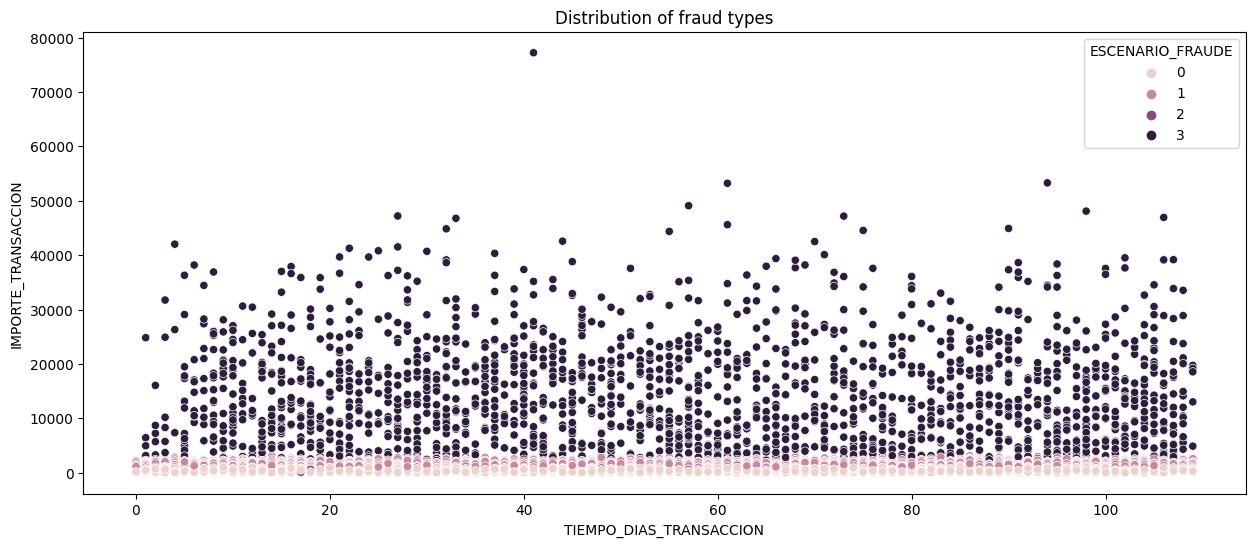

In [22]:

plt.figure(figsize=(15, 6))
sns.scatterplot(data=data, x='TIEMPO_DIAS_TRANSACCION', y='IMPORTE_TRANSACCION', hue='ESCENARIO_FRAUDE')
plt.title('Distribution of fraud types')
plt.show()


Este gráfico representa las transferencias coloreadas según su nivel de gravedad. Se puede concluir que todas aquellas transferencias que se han clasificado como no fraudulentas o leves, tienen un menor tiempo de ejecucion y son de menor importe, a comparación con aquellas que son graves, las cuales tienen importe bastante grandes. 

**Conclusiones Análisis Exploratorio**

En base al análisis realizado, se puede concluir que aproximadamente el 13,40% de las transferencias realizadas entre enero y abril fueron identificadas como fraudulentas. Es interesante observar que estas transferencias fraudulentas tienden a tener un importe promedio más elevado en comparación con las transferencias legítimas. Además, la mayoría de las operaciones fraudulentas parecen clasificarse como de tipo 1, que se consideran de gravedad leve.

# **Preprocesado de datos**

El preprocesado de datos consiste en realizar una serie de transformaciones y
manipulaciones en los datos con el objetivo de mejorar la calidad, la estructura y la
adecuación de estos para su posterior análisis o modelado.
Aquí hay algunas técnicas comunes de preprocesado de datos que se pueden aplicar
dependiendo del tipo de datos y el objetivo del análisis/modelado:
1. Manejo de datos faltantes.
2.  Exclusiones variables con varianza próxima a cero.
3. Escalado de características.
4.  Reducción de dimensionalidad y elección de características.

**Imputar datos nulos**


Anteriormente, se detectó que la variable *importe_transaccion* contiene valores ausentes. 

Como la gran mayoría de algoritmos no
aceptan observaciones incompletas, hay varias formas de tratar los datos nulos:
1. Eliminación de los registros con datos faltantes.
2. Imputar los datos faltantes utilizando el resto de información disponible.

En el caso particular de este conjunto de datos, la eliminación de registro causaría una
gran pérdida de información, por lo que no es la opción que se va a escoger.
El proceso de imputación es un tanto complejo que debe de realizarse con detenimiento
e identificando cuidadosamente que variables son adecuadas para cada tipo de
imputación.

En python se pueden imputar los valores siguiendo estos pasos:

-  Imputación vía media del predictor:
Es una técnica simple de imputación de datos que consiste en reemplazar los valores
faltantes por el valor promedio (media) de la variable predictora correspondiente.
Es importante tener en cuenta que, al utilizar la imputación vía media del predictor, estás
asumiendo que los valores faltantes no son imprescindibles y que la media de la variable
predictora es una estimación adecuada para los valores faltantes. Sin embargo, esta
técnica puede introducir cierto sesgo en los datos, ya que todos los valores faltantes se
imputan con el mismo valor promedio.
Es útil cuando los valores faltantes son aleatorios y no están relacionados con otras
variables y si los datos tienen una distribución aproximadamente normal, la imputación
vía media podría ser suficiente.

-  Imputación vía mediana del predictor:
Es una técnica de imputación de datos similar a la imputación vía media del predictor,
pero en lugar de utilizar la media, se utiliza la mediana de la variable predictora para
reemplazar los valores faltantes.
La imputación vía mediana del predictor se utiliza a menudo como una alternativa a la
imputación vía media cuando hay valores atípicos o sesgados en los datos, ya que la
mediana es una medida robusta que es menos sensible a los valores extremos.



Se analiza la distribución de los datos en la variable para analizar que técnica es la más recomendada. 

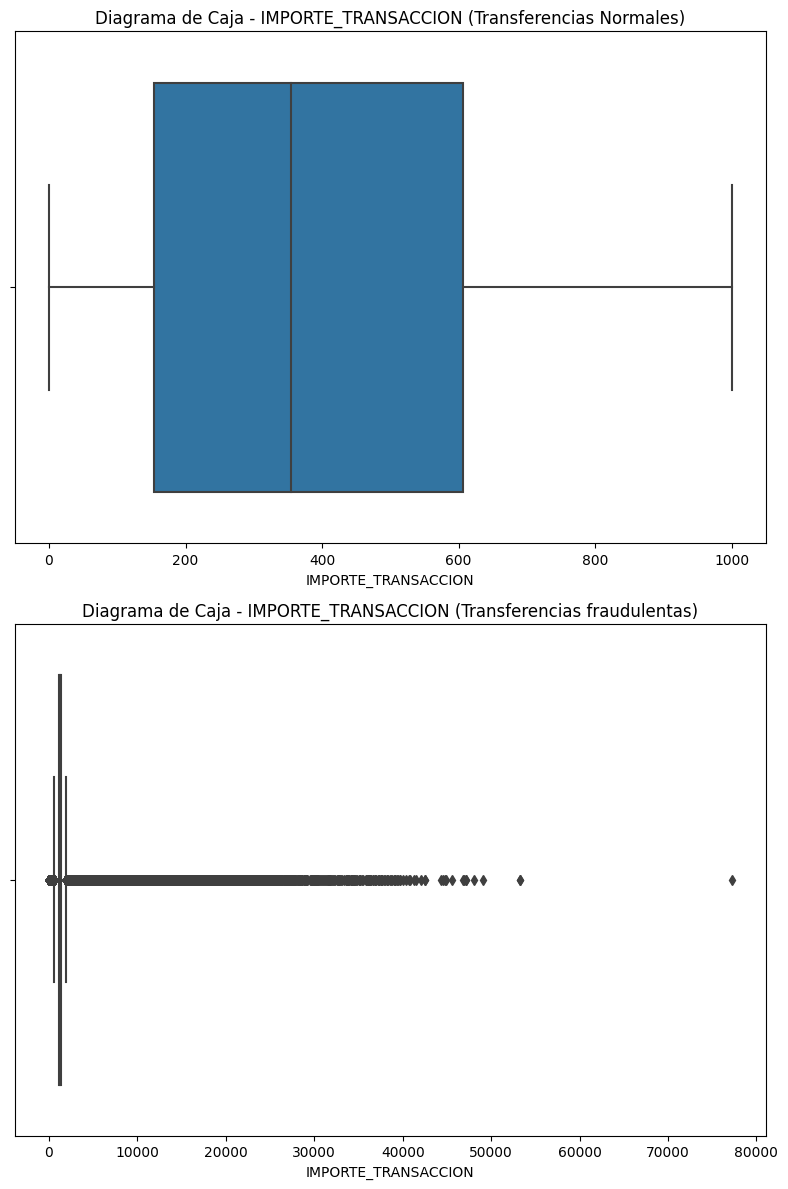

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar las transferencias normales
transferencias_normales = data[data['FRAUDE'] == 0]

# Filtrar las transferencias fraudulentas
transferencias_fraudulentas = data[data['FRAUDE'] == 1]

# Configurar el tamaño de la figura y los subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Graficar el diagrama de caja para las transferencias normales
sns.boxplot(x=transferencias_normales['IMPORTE_TRANSACCION'], ax=axes[0])

# Configurar título y etiquetas de los ejes
axes[0].set_title('Diagrama de Caja - IMPORTE_TRANSACCION (Transferencias Normales)')
axes[0].set_xlabel('IMPORTE_TRANSACCION')

# Graficar el diagrama de caja para las transferencias fraudulentas
sns.boxplot(x=transferencias_fraudulentas['IMPORTE_TRANSACCION'], ax=axes[1])

# Configurar título y etiquetas de los ejes
axes[1].set_title('Diagrama de Caja - IMPORTE_TRANSACCION (Transferencias fraudulentas)')
axes[1].set_xlabel('IMPORTE_TRANSACCION')

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()




En el código anterior, se realizan dos gráficos, uno para representar el importe de las transferencias no fraudulentas y otro para lo contrario. 

Se observa que en las trasnferencias fraudulentas hay muchos valores atipicos a comparación con las no fraudulentas.

Como la distribución de los datos es más bien distribuida y hay bastantes datos atípicos, se imputan los valores según la mediana:

In [24]:
# Rellenar los valores faltantes en cada columna con la mediana
data.fillna(data.median(), inplace=True)


<ipython-input-24-6e6fde44faf4>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.median(), inplace=True)
<ipython-input-24-6e6fde44faf4>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.median(), inplace=True)


In [25]:
# Verificar si hay valores nulos en el DataFrame
null = data.isnull().sum()

# Mostrar la cantidad de valores nulos en cada columna
print(null)


ID_TRANSACCION             0
DIA                        0
HORA                       0
ID_CLIENTE                 0
TERMINAL_ID                0
IMPORTE_TRANSACCION        0
TIEMPO_SEG_TRANSACCION     0
TIEMPO_DIAS_TRANSACCION    0
FRAUDE                     0
ESCENARIO_FRAUDE           0
dtype: int64


**Variables con varianza próxima a cero**


La eliminación de variables con varianza próxima a cero puede ayudar a simplificar el
modelo, reducir la complejidad y el ruido en los datos, y mejorar la eficiencia
computacional. Además, puede ayudar a evitar problemas como la multicolinealidad,
donde las variables están altamente correlacionadas entre sí.
Una forma común de identificar las variables con varianza cercana a cero es calcular
la varianza o desviación estándar de cada variable y compararla con un umbral
predefinido (en este caso es 0).

In [26]:
#variables proximas a ceros 
# Calcular la varianza de cada variable en el DataFrame
varianzas = data.var()
print(varianzas)
#no hay ninguna por lo que no se excluye

ID_TRANSACCION             9.162588e+10
ID_CLIENTE                 2.089963e+06
TERMINAL_ID                8.327568e+06
IMPORTE_TRANSACCION        6.777108e+05
TIEMPO_SEG_TRANSACCION     7.436109e+12
TIEMPO_DIAS_TRANSACCION    9.961626e+02
FRAUDE                     1.160189e-01
ESCENARIO_FRAUDE           1.486662e-01
dtype: float64


<ipython-input-26-f20237d5874f>:3: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  varianzas = data.var()


Entre los predictores incluidos en el modelo, no se detecta ninguno con varianza cero o
próxima a cero. Aunque esta parte puede suponer un paso de la selección de predictores,
como es un filtrado por varianza tiene que hacerse antes de estandarizar los datos,
puesto que después de este paso todos los predictores tienen varianza 1.

**Normalización de las variables**

In [27]:
# descripción de los datos 
data.describe()

,ID_TRANSACCION,ID_CLIENTE,TERMINAL_ID,IMPORTE_TRANSACCION,TIEMPO_SEG_TRANSACCION,TIEMPO_DIAS_TRANSACCION,FRAUDE,ESCENARIO_FRAUDE
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,5.242870e+05,2.504485e+03,4.997330e+03,5.330405e+02,4.722137e+06,5.415519e+01,1.339656e-01,1.440536e-01
std,3.026977e+05,1.445670e+03,2.885753e+03,8.232319e+02,2.726923e+06,3.156204e+01,3.406155e-01,3.855726e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.621435e+05,1.253000e+03,2.503000e+03,1.801600e+02,2.367256e+06,2.700000e+01,0.000000e+00,0.000000e+00
50%,5.242870e+05,2.506000e+03,4.993000e+03,4.219400e+02,4.715511e+06,5.400000e+01,0.000000e+00,0.000000e+00
75%,7.864305e+05,3.765000e+03,7.495000e+03,7.501900e+02,7.088192e+06,8.200000e+01,0.000000e+00,0.000000e+00
max,1.048574e+06,4.999000e+03,9.999000e+03,7.721250e+04,9.454063e+06,1.090000e+02,1.000000e+00,3.000000e+00


En este caso particular, no parece ser necesario aplicar normalización a las variables, dado que la mayoría de ellas son identificadores únicos. Además, al analizar las varianzas calculadas previamente, no se observa una diferencia significativa entre ellas. Por lo tanto, no hay evidencia suficiente para justificar la normalización en este contexto.

## Selección caracteristicas 

La reducción de la dimensionalidad basada en correlación es una técnica que se utiliza
para simplificar conjuntos de datos grandes y complejos, mejorar la interpretación de los
resultados y evitar problemas asociados con la multicolinealidad.

Para realizar una reducción de la dimensionalidad basada en correlación, se realiza una matriz de correlaciones que  muestra las relaciones de correlación entre los pares de variables.
Aquellas que tengan un nivel de correlación negativo o igual a 0 se eliminan.

Antes de realizar esta matriz, las variables DIA y HORA son de tipo datetime. Estas variables han sido útiles para ayudar a identificar patrones (como se vió anteriormente) entre las transferencias fraudulentas, pero no aportan valor al modelo por lo que de momento se omiten del dataset.

In [28]:
# Crear una lista con las columnas a eliminar
columnas_eliminar = ['HORA', 'DIA']

# Eliminar las columnas del dataset
data = data.drop(columnas_eliminar, axis=1)


In [29]:
#se han eliminado las columnas de la tabla
data.head()

,ID_TRANSACCION,ID_CLIENTE,TERMINAL_ID,IMPORTE_TRANSACCION,TIEMPO_SEG_TRANSACCION,TIEMPO_DIAS_TRANSACCION,FRAUDE,ESCENARIO_FRAUDE
0,0,596,3156,533.07,31,0,0,0
1,1,4961,3412,808.56,130,0,0,0
2,2,2,1365,1442.94,476,0,1,1
3,3,4128,8737,620.65,569,0,0,0
4,4,927,9906,490.66,634,0,0,0


In [30]:
# Calcular la correlación entre 'FRAUDE' y el resto de variables
correlation = data.corr()['FRAUDE']

# Mostrar la correlación
print(correlation)


ID_TRANSACCION             0.002659
ID_CLIENTE                 0.004046
TERMINAL_ID               -0.002632
IMPORTE_TRANSACCION        0.428538
TIEMPO_SEG_TRANSACCION     0.002662
TIEMPO_DIAS_TRANSACCION    0.002668
FRAUDE                     1.000000
ESCENARIO_FRAUDE           0.949924
Name: FRAUDE, dtype: float64


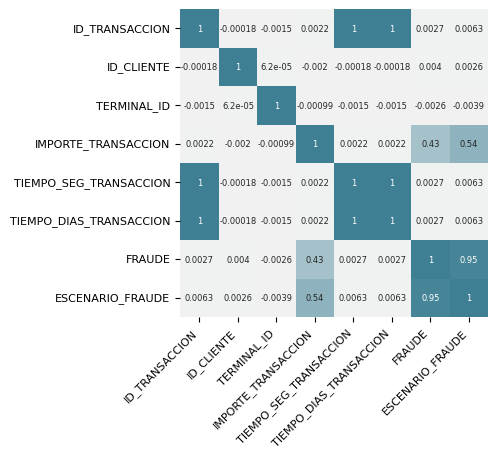

In [31]:
# Heatmap matriz de correlaciones
# ==============================================================================
# Calcular correlacion entre variables
correlation_matrix = data.corr()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    correlation_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 8)


Con esta tabla, se analiza las variables y se seleccionan según mayor correlación tengan. En este caso se seleccionan aquellas que tengan mayor coeficiente y se elimina la variable Terminal ID, ya que tiene un valor negativo.



In [32]:
# Crear una lista con las columnas a eliminar
columna_eliminar = ['TERMINAL_ID']

# Eliminar las columnas del dataset
data = data.drop(columna_eliminar, axis=1)

In [33]:
data.shape

(1048575, 7)

Con esta técnica, la tabla ha pasado de tener 10 variables, a tener 7. 

Una vez terminado el proceso de reducción de la dimensionalidad, se pasa al entrenamiento del modelo.

# **Implementación de un modelo**

Dividir los datos en conjuntos separados es muy importante para entrenar y evaluar el
rendimiento de un modelo o algoritmo.
El tamaño adecuado depende en gran medida de la cantidad de datos disponibles, en
este caso se ha escogido un 75% para los datos de entrenamiento y el resto, un 25%
para los datos de prueba.

In [34]:
from sklearn.model_selection import train_test_split

# Separate the target variable from the features
X = data.drop('FRAUDE', axis=1)
y = data['FRAUDE']

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [44]:
data.columns

Index(['ID_TRANSACCION', 'ID_CLIENTE', 'IMPORTE_TRANSACCION',
       'TIEMPO_SEG_TRANSACCION', 'TIEMPO_DIAS_TRANSACCION', 'FRAUDE',
       'ESCENARIO_FRAUDE'],
      dtype='object')

**Red Neuronal**

Las redes neuronales en inteligencia artificial (IA) son un tipo de modelo o algoritmo que se inspira en el funcionamiento del cerebro humano para realizar tareas de aprendizaje y toma de decisiones. Estas redes están compuestas por un conjunto de unidades de procesamiento llamadas neuronas artificiales o nodos, que están interconectadas y organizadas en capas.

En una red neuronal, cada neurona artificial recibe una serie de entradas, realiza cálculos en función de esas entradas y produce una salida. Esta salida puede ser la entrada de otra neurona en la misma capa o en la siguiente capa de la red.

Las redes neuronales pueden tener múltiples capas, lo que se conoce como redes neuronales profundas o redes neuronales multicapa. Cada capa en la red neuronal puede tener un número variable de neuronas, y las conexiones entre las neuronas están asociadas con pesos que determinan la influencia de una neurona en otra.

Durante el proceso de entrenamiento de una red neuronal, se ajustan los pesos de las conexiones entre las neuronas para que la red pueda aprender a realizar tareas específicas.

Código que define y entrena el modelo de red neuronal:

In [35]:
#librerias para utulizar la red neuronal
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Establecer la semilla aleatoria para NumPy
np.random.seed(123)

# Establecer la semilla aleatoria para TensorFlow
tf.random.set_seed(123)

# Definir el modelo
modelRed = Sequential()
modelRed.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
modelRed.add(Dense(16, activation='relu'))
modelRed.add(Dense(1, activation='sigmoid'))

# Compile the model
modelRed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar modelo
modelRed.fit(X_train, y_train, epochs=10, batch_size=32) #se están tomando 32 muestras de entrenamiento a la vez para calcular el gradiente y actualizar los pesos del modelo. 

# Evaluar el modelo
accuracy = modelRed.evaluate(X_test, y_test)[1]

print("Accuracy:", accuracy)



Epoch 1/10
24576/24576 [==============================] - 45s 2ms/step - loss: 1173.3131 - accuracy: 0.8070
Epoch 2/10
24576/24576 [==============================] - 44s 2ms/step - loss: 50.8012 - accuracy: 0.8403
Epoch 3/10
24576/24576 [==============================] - 42s 2ms/step - loss: 0.3957 - accuracy: 0.8665
Epoch 4/10
24576/24576 [==============================] - 47s 2ms/step - loss: 0.5454 - accuracy: 0.8663
Epoch 5/10
24576/24576 [==============================] - 49s 2ms/step - loss: 0.3943 - accuracy: 0.8663
Epoch 6/10
24576/24576 [==============================] - 75s 3ms/step - loss: 0.4055 - accuracy: 0.8663
Epoch 7/10
24576/24576 [==============================] - 54s 2ms/step - loss: 0.3933 - accuracy: 0.8663
Epoch 8/10
24576/24576 [==============================] - 45s 2ms/step - loss: 0.4023 - accuracy: 0.8663
Epoch 9/10
24576/24576 [==============================] - 43s 2ms/step - loss: 0.4003 - accuracy: 0.8663
Epoch 10/10
8192/8192 [============================

**Explicación del código**

1. Se importan las librerías necesarias: numpy para manipulación numérica, tensorflow para construir y entrenar modelos de redes neuronales, pandas para el manejo de datos en forma de DataFrames.

2. Se establece la semilla aleatoria para NumPy mediante np.random.seed. Esto garantiza que los resultados sean reproducibles, es decir, al ejecutar el código varias veces se obtendrán los mismos resultados aleatorios.

3. Se establece la semilla aleatoria para TensorFlow mediante tf.random.set_seed. Al igual que con NumPy, esto asegura la reproducibilidad de los resultados aleatorios generados por TensorFlow.

4. Se define el modelo de red neuronal utilizando el tipo de modelo Sequential de Keras, que es un modelo lineal de capas apiladas. El modelo consta de tres capas Dense, que son capas totalmente conectadas. 
La primera capa tiene 32 unidades de neuronas y utiliza la función de activación 'relu'. La segunda capa tiene 16 unidades de neuronas y también utiliza la función de activación 'relu'. La última capa tiene 1 unidad de neurona y utiliza la función de activación 'sigmoid', ya que es un problema de clasificación binaria.

  La función de activación '**relu**' es una abreviatura de "Rectified Linear Unit" (Unidad Lineal Rectificada). Es una función matemática que se utiliza comúnmente en redes neuronales como función de activación en las capas ocultas.

  La función de activación '**sigmoid**' es una función matemática utilizada en redes neuronales para realizar una transformación no lineal en la salida de una neurona. 

5. Se compila el modelo utilizando el optimizador 'adam' y la función de pérdida 'binary_crossentropy', adecuadas para problemas de clasificación binaria. Además, se especifica la  medición de la métrica de precisión ('accuracy') durante el entrenamiento.

  El optimizador 'Adam' es un algoritmo de optimización popular utilizado en redes neuronales para ajustar los pesos y los sesgos de las capas de la red durante el entrenamiento. Adam es una abreviatura de "Adaptive Moment Estimation". 

  La función de pérdida 'binary_crossentropy', también conocida como entropía cruzada binaria, se utiliza cuando el objetivo es predecir una variable binaria, es decir, cuando se tienen dos clases posibles.

6. Se entrena el modelo utilizando los datos de entrenamiento X_train y las etiquetas de entrenamiento y_train. Se especifica un número de épocas (10) y un tamaño de lote (32) para el entrenamiento.

7. Se evalúa el rendimiento del modelo utilizando los datos de prueba X_test y las etiquetas de prueba y_test. Se calcula la precisión del modelo y se guarda en la variable accuracy.

8. Se imprime el valor de la precisión obtenida.



Finalmente, se muestra la precisión obtenida en la evaluación del modelo en el conjunto de prueba. 

Se muestra la precisión de cada época y 
en este caso, el modelo alcanza una precisión finalde 0.8651 (86.51%), lo que indica que es capaz de clasificar correctamente el 86.51% de las transferencias como fraudulentas o no fraudulentas en el conjunto de prueba.
Además se observa que el modelo alcanzó su máxima precisión en la época 4. 


# **Evaluación del modelo**

**Curva de aprendizaje** 

La curva de aprendizaje es una técnica utilizada para analizar el rendimiento de un modelo de red neuronal a medida que se incrementa la cantidad de datos de entrenamiento. La curva de aprendizaje muestra cómo evoluciona el error o la métrica de rendimiento del modelo a medida que se incrementa el tamaño del conjunto de entrenamiento.

Código:

epochs: Número de épocas o iteraciones completas a través de los datos de entrenamiento.
batch_size: Tamaño del lote utilizado en cada paso de actualización de los pesos del modelo.


Epoch 1/10
24576/24576 [==============================] - 82s 3ms/step - loss: 0.4001 - accuracy: 0.8663 - val_loss: 0.3931 - val_accuracy: 0.8663
Epoch 2/10
24576/24576 [==============================] - 72s 3ms/step - loss: 0.3959 - accuracy: 0.8663 - val_loss: 0.3931 - val_accuracy: 0.8663
Epoch 3/10
24576/24576 [==============================] - 70s 3ms/step - loss: 0.3933 - accuracy: 0.8663 - val_loss: 0.3931 - val_accuracy: 0.8663
Epoch 4/10
24576/24576 [==============================] - 73s 3ms/step - loss: 0.4018 - accuracy: 0.8663 - val_loss: 0.3935 - val_accuracy: 0.8663
Epoch 5/10
24576/24576 [==============================] - 72s 3ms/step - loss: 0.3973 - accuracy: 0.8663 - val_loss: 0.3938 - val_accuracy: 0.8663
Epoch 6/10
24576/24576 [==============================] - 72s 3ms/step - loss: 0.3972 - accuracy: 0.8663 - val_loss: 0.3930 - val_accuracy: 0.8663
Epoch 7/10
24576/24576 [==============================] - 83s 3ms/step - loss: 0.4028 - accuracy: 0.8663 - val_loss: 0

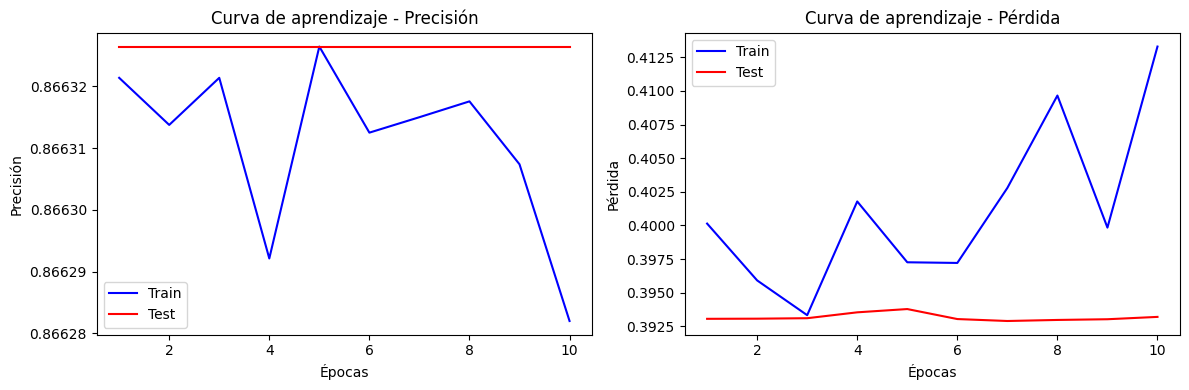

In [38]:
#import matplotlib.pyplot as plt

# Obtener el historial de precisión y pérdida durante el entrenamiento
history = modelRed.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X, y))

# Extraer la precisión y pérdida del historial de datos de ambos conjuntos de datos
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

#rango de epocas utilizadas en el modelo
epochs = range(1, len(train_accuracy) + 1)

# Crear el gráfico de las curvas de aprendizaje

#tamaño gráfico
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
#traza las curvas de precisión del conjunto de entrenamiento y del conjunto de prueba en función del número de épocas
plt.plot(epochs, train_accuracy, 'b', label='Train')
plt.plot(epochs, test_accuracy, 'r', label='Test')
plt.title('Curva de aprendizaje - Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Train')
plt.plot(epochs, test_loss, 'r', label='Test')
plt.title('Curva de aprendizaje - Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


 Según la curva de aprendizaje, el modelo de red neuronal alcanza una precisión constante sin mejorar más allá del 86.63%. Esto sugiere la presencia de un posible sobreajuste y la necesidad de evaluar otras estrategias, como ajustar los hiperparámetros del modelo o aumentar el tamaño del conjunto de datos de entrenamiento, para mejorar su rendimiento.


Los gráficos muestran el desempeño por época del entrenamiento del modelo en ambos conjuntos de datos.

En el primer gráfico se observa que los datos de entrenamiento tienen su pico más alto de precisión en la época 5 y va disminuyendo a partir de ahí. 

A comparación con el gráfico de perdidas, se observa que según aumenta la época, las perdidas en los datos de entrenamiento aumentan.

In [39]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report

# Obtener las etiquetas predichas por el modelo
y_pred = modelRed.predict(X_test)
y_pred_classes = (y_pred >= 0.5).astype(int)

# Generar el informe de clasificación
report = classification_report(y_test, y_pred_classes)

# Mostrar la tabla de evaluación
print("Tabla de Evaluación de la Red Neuronal:")
print(report)



8192/8192 [==============================] - 11s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tabla de Evaluación de la Red Neuronal:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    226796
           1       0.00      0.00      0.00     35348

    accuracy                           0.87    262144
   macro avg       0.43      0.50      0.46    262144
weighted avg       0.75      0.87      0.80    262144



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


El problema experimentando con la red neuronal puede deberse a un desequilibrio en los datos de entrenamiento. Según las métricas , el modelo tiene una alta precisión (0.87) pero un recall y f1-score de 0.00 para la clase "1" (transferencias fraudulentas). Esto indica que el modelo no logra detectar correctamente las transferencias fraudulentas.

Una posible solución es tratar el desequilibrio de clases utilizando técnicas como el sobremuestreo o el submuestreo. Estas técnicas permiten equilibrar el conjunto de datos de manera que haya una cantidad similar de muestras para ambas clases.

Utilizando la biblioteca imbalanced-learn se puede aplicar el submuestreo.



In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import RandomOverSampler

# Establecer la semilla aleatoria para NumPy
np.random.seed(123)

# Establecer la semilla aleatoria para TensorFlow
tf.random.set_seed(123)

# Aplicar sobremuestreo
oversampler = RandomOverSampler(random_state=123)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Definir el modelo
modelRed = Sequential()
modelRed.add(Dense(32, activation='relu', input_dim=X_train_resampled.shape[1]))
modelRed.add(Dense(16, activation='relu'))
modelRed.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
modelRed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los datos sobremuestreados
modelRed.fit(X_train_resampled, y_train_resampled, epochs=15, batch_size=32)

# Evaluar el modelo
accuracy = modelRed.evaluate(X_test, y_test)[1]

print("Accuracy:", accuracy)


Epoch 1/15
42582/42582 [==============================] - 75s 2ms/step - loss: 1690.6898 - accuracy: 0.7269
Epoch 2/15
42582/42582 [==============================] - 74s 2ms/step - loss: 240.4738 - accuracy: 0.7913
Epoch 3/15
42582/42582 [==============================] - 74s 2ms/step - loss: 48.9515 - accuracy: 0.8343
Epoch 4/15
42582/42582 [==============================] - 76s 2ms/step - loss: 0.5143 - accuracy: 0.9094
Epoch 5/15
42582/42582 [==============================] - 79s 2ms/step - loss: 0.4115 - accuracy: 0.9174
Epoch 6/15
42582/42582 [==============================] - 75s 2ms/step - loss: 0.3336 - accuracy: 0.9219
Epoch 7/15
42582/42582 [==============================] - 74s 2ms/step - loss: 0.3357 - accuracy: 0.9245
Epoch 8/15
42582/42582 [==============================] - 83s 2ms/step - loss: 0.2518 - accuracy: 0.9255
Epoch 9/15
42582/42582 [==============================] - 75s 2ms/step - loss: 0.2509 - accuracy: 0.9275
Epoch 10/15
42582/42582 [========================

Añadiendo esta mejora, el modelo mejora significaticamente, pasando predecir el 96.99%. 

Hay que destacar que no solo ha mejorado por aplicar el submuestreo, sino que también se han aumentado el número de épocas.
A medida que avanza el entrenamiento, la pérdida disminuye y la precisión tiende a mejorar.


In [49]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report

# Obtener las etiquetas predichas por el modelo
y_pred = modelRed.predict(X_test)
y_pred_classes = (y_pred >= 0.5).astype(int)

# Generar el informe de clasificación
report = classification_report(y_test, y_pred_classes)

# Mostrar la tabla de evaluación
print("Tabla de Evaluación de la Red Neuronal:")
print(report)


8192/8192 [==============================] - 10s 1ms/step
Tabla de Evaluación de la Red Neuronal:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    226796
           1       0.84      0.96      0.90     35348

    accuracy                           0.97    262144
   macro avg       0.92      0.96      0.94    262144
weighted avg       0.97      0.97      0.97    262144



En este caso, se puede observar que para la clase 0, se alcanza una precisión del 99%, lo que indica que la mayoría de las transacciones clasificadas como clase 0 fueron realmente transacciones legítimas. El recall (también conocido como sensibilidad) es del 97%, lo que indica que la red neuronal pudo identificar correctamente la mayoría de las transacciones legítimas. El f1-score, que combina precisión y recall, es del 98% para la clase 0.

Para la clase 1, se observa una precisión del 84%, lo que indica que la red neuronal acertó en la clasificación de un alto porcentaje de las transacciones fraudulentas. El recall es del 96%, lo que indica que la red neuronal logró detectar la mayoría de las transacciones fraudulentas. El f1-score para la clase 1 es del 90%. 

En general, el modelo muestra un alto desempeño con una precisión global del 97%. Esto significa que la red neuronal pudo clasificar correctamente la mayoría de las transacciones tanto legítimas como fraudulentas en el conjunto de prueba.

**Matriz de confusión**

La matriz de confusión es una herramienta que se utiliza para evaluar el rendimiento de un modelo de clasificación. Es una tabla que muestra el recuento de las predicciones realizadas por el modelo en comparación con las clases verdaderas.

La matriz de confusión organiza los resultados de la clasificación en una tabla de 2x2 (en el caso de un problema binario) o de nxn (en el caso de un problema multiclase), donde n es el número de clases. 

El código de la matriz de confusión del modelo de red en Python es el siguiente:

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener las etiquetas predichas por el modelo
y_pred = (y_pred >= 0.5) # etiquetas binarias (0 o 1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

print(cm)


[[220492   6304]
 [  1579  33769]]


La matriz de confusión proporcionada muestra los resultados de la clasificación del modelo en el conjunto de datos de prueba. Aquí está la interpretación de los valores en la matriz:

1. Verdaderos negativos (TN): 220,492
2. Falsos positivos (FP): 6,304
3. Falsos negativos (FN): 1,579
4. Verdaderos positivos (TP): 33,769

La matriz de confusión muestra cómo se clasificaron las muestras en cada una de estas categorías. Puede interpretarse de la siguiente manera:

 - 220,492 muestras fueron clasificadas correctamente como negativas (clase 0).

 - 6,304 falsos positivos, lo que significa que todas las muestras negativas fueron clasificadas mayoritariamente  de forma correcta.

 -  1,579 muestras negativas que fueron clasificadas incorrectamente como positivas.

 - 33,769 muestras positivas (clase 1) fueron clasificadas correctamente.

 Estos resultados obtenidos, hacen el modelo se considere bastante bueno a la hora de predecir y clasificar las transferencias.






# **Comparación**

Para hacer una comparación de resultados entre varios algoritmos de Inteligencia Artificial se ha escogido un modelo de Regresión Lineal Múltiple. 

La regresión lineal múltiple es un método estadístico utilizado para modelar la relación entre una variable dependiente y dos o más variables independientes. Es una extensión de la regresión lineal simple, que considera solo una variable independiente.

En la regresión lineal múltiple, el objetivo es encontrar una ecuación lineal que mejor se ajuste a los datos y permita predecir el valor de la variable dependiente en función de las variables independientes. 

El código es el siguiente:

In [41]:
#importar librerías para el modelo de regresion
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Crear el modelo de regresión lineal
modelLineal= LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
modelLineal.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba
y_pred_regresion = modelLineal.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred_regresion)
print("Error cuadrático medio:", mse)

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y_test, y_pred_regresion)
print("Coeficiente de determinación (R^2):", r2)


Error cuadrático medio: 0.010069930372974656
Coeficiente de determinación (R^2): 0.9136810647524887


El error cuadrático medio (MSE) obtenido es de 0.0090075. Esto significa que, en promedio, las predicciones del modelo se desvían en aproximadamente 0.0100 unidades al cuadrado de los valores reales. Un valor de MSE más bajo indica un mejor ajuste del modelo.

El coeficiente de determinación (R^2) obtenido es de 0.9136. Este valor indica que aproximadamente el 91.36% de la varianza en la variable objetivo puede ser explicada por el modelo de regresión lineal múltiple. Un valor de R^2 más cercano a 1 indica un mejor ajuste del modelo, lo que sugiere que el modelo es capaz de capturar una gran cantidad de la variabilidad en los datos de salida.

# **Conclusiones de los algoritmos**


En el caso de la regresión lineal, se logró un Error Cuadrático Medio (MSE) de 0.0101, lo que indica una baja discrepancia entre los valores predichos y los valores reales. Además, el Coeficiente de Determinación (R^2) de 0.9113 destaca que aproximadamente el 91.13% de la variabilidad en los datos de respuesta puede ser explicada por el modelo de regresión lineal. Estos resultados indican un buen ajuste del modelo lineal a los datos y una capacidad significativa para predecir los resultados.

Por otro lado, la red neuronal mostró finalmente una precisión del 96.99% en la tarea de clasificación. 

En general, se puede concluir que el modelo de red neuronal tiene un mejor desempeño en comparación con el modelo de regresión lineal, ya que tiene una mayor precisión y los valores de perdida en el último modelo eran relativamente bajos.